Ilan Meyrowitsch +972-58-4004880

In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  8 15:36:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
!cp drive/MyDrive/dontpatronizeme_categories.tsv .

In [3]:
!cp drive/MyDrive/dontpatronizeme_pcl.tsv .

In [1]:
!cp drive/MyDrive/test_me.py .
import test_me


In [4]:
from test_me import TestMe

i_test = TestMe()
i_test.load_test()



In [9]:
i_test.test_label

array([0, 0, 0, ..., 1, 1, 1])

In [5]:
i_test.test_set.shape

(10469,)

In [7]:
i_test.test_set[1000]

'"is first captured the city in 2014 and tens of thousands who fled are badly in need of aid , with charities saying "" camps are bursting at the seams "" ."'

In [11]:
import random
import os
from urllib import request

In [12]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [13]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py


In [14]:
from dont_patronize_me import DontPatronizeMe
# Initialize a dpm (Don't Patronize Me) object.
# It takes two areguments as input: 
# (1) Path to the directory containing the training set files, which is the root directory of this notebook.
# (2) Path to the test set, which will be released when the evaluation phase begins. In this example, 
# we use the dataset for Subtask 1, which the code will load without labels.
dpm = DontPatronizeMe('.', 'dontpatronizeme_pcl.tsv')

In [15]:
# This method loads the subtask 1 data
dpm.load_task1()
# which we can then access as a dataframe
dpm.train_task1_df.head()

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"we 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"in libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""white house press secretary sean spicer said ...",0,0
3,4,@@7811231,disabled,nz,council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" just like we received migrants fleeing el ...",0,0


In [16]:
# Same for subtask 2
dpm.load_task2()
# which we can then access as a dataframe
dpm.train_task2_df.head()

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


,par_id,art_id,text,keyword,country,label
0,4046,@@14767805,we also know that they can benefit by receivin...,hopeless,us,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,@@7896098,pope francis washed and kissed the feet of mus...,refugee,ng,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,@@17252299,many refugees do n't want to be resettled anyw...,refugee,ng,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,@@3002894,"""budding chefs , like """" fred """" , """" winston ...",in-need,ie,"[1, 0, 0, 1, 1, 1, 0]"
4,4089,@@25597822,"""in a 90-degree view of his constituency , one...",homeless,pk,"[1, 0, 0, 0, 0, 0, 0]"


In [17]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

My part

In [18]:
!cp drive/MyDrive/ilan_model.py .
import ilan_model

In [19]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [20]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

Load Dataset dontpatronizeme_pcl for task 1

In [22]:
#task1_df = pd.read_csv("dontpatronizeme_pcl.tsv", delimiter='\t', header=None, names=['par_id', 'art_id', 'keyword', 'country','text','label'])

In [23]:
dpm.train_task1_df.shape

(10469, 7)

In [24]:
dpm.train_task1_df.sample(10)

,par_id,art_id,keyword,country,text,label,orig_label
6077,6078,@@4014100,homeless,lk,"feb 16 , colombo : pursuing another promise in...",0,1
6811,6812,@@8314692,migrant,hk,"tsang wrote as an immigrant , he was impressed...",0,0
3457,3458,@@25643783,migrant,pk,an undocumented immigrant family from guatemal...,0,0
9901,9902,@@19004735,disabled,gh,this will involve looking for signals such as ...,0,0
4086,4087,@@1692174,homeless,us,homelessness among the elderly can happen sudd...,0,0
8248,8249,@@8557367,women,nz,"kavanna 's mum , carolyn ogg , has been dashin...",0,0
1806,1807,@@21403532,women,my,kota kinabalu : statistics show that breast ca...,0,0
6057,6058,@@1197636,disabled,us,conservatives will have to square this derange...,0,0
631,632,@@15472541,poor-families,ie,""""""" these children are from poor families , th...",0,1
5159,5160,@@7691860,poor-families,za,welfare grants that 17 million people depend o...,0,0


Load Dataset dontpatronizeme_categories for task 2

In [25]:
#task2_df = pd.read_csv("dontpatronizeme_categories.tsv", delimiter='\t', header=None, names=['par_id', 'art_id','text', 'keyword', 'country','label'])

In [26]:
#task2_df.shape

In [27]:
#task2_df.sample(10)

In [28]:
# Create sentence and label lists
sentences = dpm.train_task1_df.text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence[:511] + " [SEP]" for sentence in sentences]
labels = dpm.train_task1_df.label.values


In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 926331.48B/s]


Tokenize the first sentence:
['[CLS]', 'we', "'", 're', 'living', 'in', 'times', 'of', 'absolute', 'insanity', ',', 'as', 'i', "'", 'm', 'pretty', 'sure', 'most', 'people', 'are', 'aware', '.', 'for', 'a', 'while', ',', 'waking', 'up', 'every', 'day', 'to', 'check', 'the', 'news', 'seemed', 'to', 'carry', 'with', 'it', 'the', 'same', 'feeling', 'of', 'panic', 'and', 'dread', 'that', 'action', 'heroes', 'probably', 'face', 'when', 'they', "'", 're', 'trying', 'to', 'decide', 'whether', 'to', 'cut', 'the', 'blue', 'or', 'green', 'wire', 'on', 'a', 'ticking', 'bomb', '-', '-', 'except', 'the', 'bomb', "'", 's', 'instructions', 'long', 'ago', 'burned', 'in', 'a', 'fire', 'and', 'imminent', 'catastrophe', 'seems', 'the', 'like', '##liest', 'outcome', '.', 'it', "'", 's', 'hard', 'to', 'stay', 'that', 'on', '-', 'edge', 'for', 'that', 'long', ',', 'though', ',', 'so', 'it', "'", 's', 'natural', '[SEP]']


In [30]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 512

In [31]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [32]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [33]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [34]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [35]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [36]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
#batch_size = 32
batch_size = 8
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

Train Model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

In [38]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [39]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [40]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [41]:
#import torch
#torch.cuda.empty_cache()

In [42]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.32002892676608063


Epoch:  25%|██▌       | 1/4 [11:18<33:55, 678.43s/it]

Validation Accuracy: 0.9017175572519084
Train loss: 0.31790317165236825


Epoch:  50%|█████     | 2/4 [22:35<22:34, 677.47s/it]

Validation Accuracy: 0.9017175572519084
Train loss: 0.32049332480365333


Epoch:  75%|███████▌  | 3/4 [33:52<11:17, 677.27s/it]

Validation Accuracy: 0.9017175572519084
Train loss: 0.3193406341297011


Epoch: 100%|██████████| 4/4 [45:08<00:00, 677.24s/it]

Validation Accuracy: 0.9017175572519084


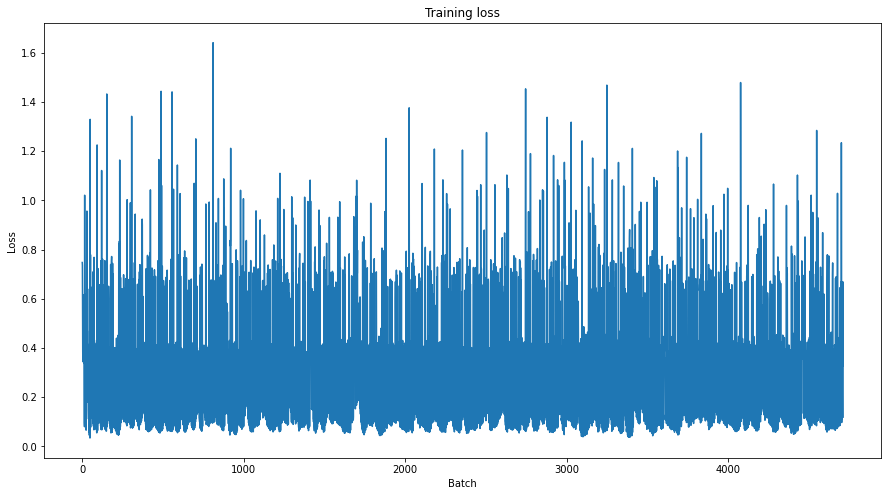

In [43]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [44]:
# Upload the test file from your local drive
#from google.colab import files
#uploaded = files.upload()


In [45]:
#df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
#sentences = df.sentence.values
sentences = i_test.test_set

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence[:511] + " [SEP]" for sentence in sentences]
#labels = df.label.values
labels = i_test.test_label
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [46]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [51]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#model.save_pretrained('saved_model/my_model') 

In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
model_save_name = 'classifier.pt'
path_google_drive = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path_google_drive)

In [53]:
model_save_name = 'NLP_model_1.pt'
path_google_drive = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model, path_google_drive)

In [ ]:
model_loaded2 = torch.load(path_google_drive)

In [ ]:
#model_loaded = TheModelClass(*args, **kwargs)
model_loaded = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_loaded.load_state_dict(torch.load(path_google_drive))
model_loaded.eval()

In [ ]:
#from transformers import BertTokenizer, BertForSequenceClassification
inputs = tokenizer.tokenize("Hello, my dog is cute")
#inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model_loaded.classifier(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits


# New section

In [ ]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [ ]:
matthews_set

In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [ ]:
matthews_corrcoef(flat_true_labels, flat_predictions)

In [ ]:
# first, we need to create the res/ and ref/ folders, which the evaluator expects
!mkdir ref res

In [ ]:
#dpm.load_test()


In [ ]:
#dpm.test_set

In [ ]:
# random predictions for task 1
preds_task1 = [[random.randint(0,1)] for k in range(0,len(dpm.test_set))]
labels2file(preds_task1, os.path.join('res/', 'task1.txt'))

In [ ]:
# random predictions for task 2
preds_task2 = [[random.choice([0,1]) for k in range(7)] for k in range(0,len(dpm.test_set))]
labels2file(preds_task2, os.path.join('res/', 'task2.txt'))

In [ ]:
#dpm.train_task1_df['text']

In [ ]:
#dpm.train_task2_df.label.tolist()

In [ ]:
# for subtask 1 (we convert our list of labels into a list of lists to make 
# it compatible with the labels2file function)
labels2file(dpm.train_task1_df['label'].apply(lambda x:[x]).tolist(), os.path.join('ref/', 'task1.txt'))
# and for subtask 2
labels2file(dpm.train_task2_df.label.tolist(), os.path.join('ref/', 'task2.txt'))

In [ ]:
# Now, we can just call the official scorer, which takes an input_directory and an output_directory
# as arguments. In this example, both will be the root directory of this notebook.
!python3 evaluation.py . .

In [ ]:
# The scorer generated a results file called "scores.txt". 
# We can now see the performance of a random baseline on the training set.
!cat scores.txt